# Training

## Risoluzione dipendenze e caricamento dataset

In [1]:
# Installa tutte le dipendenze.
!pip install -r requirements.txt

In [2]:
# Importa tutte le librerie necessarie.
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import make_pipeline

In [3]:
# Carica i due dataset di training e di test.
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## Analisi preliminare e pulizia del dataset

In [4]:
# Vediamo quale è la dimensione dei due set.
print('Dimensione train set: ' + str(train.shape))
print('Dimensione test  set: ' + str(test.shape))

Dimensione train set: (4507, 21)
Dimensione test  set: (1127, 21)


In [5]:
# Mi faccio un'idea di come è fatto il training set, visualizzandone le prime 10 righe.
train.head(10)

,Churn,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,No,3798-EPWRR,Female,1,No,No,2,Yes,No,DSL,...,No,No,No,No,No,Month-to-month,No,Electronic check,43.95,85.1
1,No,0744-GKNGE,Female,0,Yes,Yes,64,Yes,Yes,Fiber optic,...,No,No,Yes,No,No,Month-to-month,Yes,Bank transfer (automatic),86.80,5327.25
2,No,1755-RMCXH,Male,0,Yes,Yes,2,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.30,40.25
3,No,8200-LGKSR,Male,0,Yes,No,71,Yes,Yes,DSL,...,No,Yes,Yes,Yes,Yes,Two year,No,Electronic check,83.20,6126.1
4,No,4698-KVLLG,Female,1,No,No,51,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),19.60,967.9
5,No,5876-QMYLD,Female,0,Yes,Yes,23,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,20.05,415.1
6,No,7956-XQWGU,Male,0,No,No,27,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Credit card (automatic),19.40,460.25
7,Yes,9231-ZJYAM,Female,1,No,No,4,Yes,No,Fiber optic,...,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,78.85,292.8
8,Yes,2037-SGXHH,Male,0,Yes,Yes,38,Yes,Yes,Fiber optic,...,Yes,Yes,No,Yes,No,Month-to-month,Yes,Electronic check,94.65,3624.3
9,No,8752-IMQOS,Male,0,Yes,Yes,5,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,20.10,85.1


No     3296
Yes    1211
Name: Churn, dtype: int64


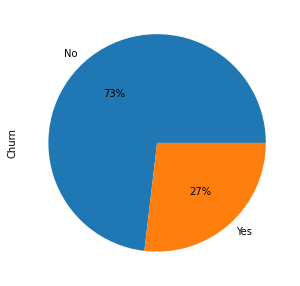

In [6]:
# Per prima cosa, vediamo come si ripartiscono i clienti nelle due categorie.
churn_value_counts = train['Churn'].value_counts()
print(churn_value_counts)
plot = churn_value_counts.plot.pie(figsize = (5, 5), autopct = '%1.0f%%')

Sembra che i clienti che vogliono rimanere ancora legati al proprio operatore telefonico siano molti di più di quelli che hanno intenzione di abbandonarlo.

In [7]:
# Mostro l'elenco di tutte le colonne del dataset, insieme al loro tipo di dato.
train.dtypes

Churn                object
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
dtype: object

Sembrano esserci alcuni problemi in questo dataset:
  - Per cominciare, non gradisco il fatto che alcune colonne inizino con una lettera minuscola e altre con una maiscola. È più un aspetto estetico che funzionale comunque.
  
  - La colonna `SeniorCitizen` è di tipo intero, ma in realtà è una feature categorica.
    Per evitare confusione in questa prima fase di analisi dei dati, va convertita in un valore di tipo `object` (sebbene poi sarà comunque necessario riconvertirla in intero, dato che gli algoritmi di ML hanno bisogno di feature numeriche).
    
  - La colonna `TotalCharges` è di tipo `object`, ma in realtà è una feature numerica (reale per la precisione), dal momento che rappresenta un quantitativo in denaro.
    Va quindi convertita in `float`.
    
Definisco quindi qui sotto una funzione per effettuare una prima pulizia dei dati.

In [8]:
def clean(data):
    
    # Crea una copia dei dati per non corrompere quelli originali.
    data = data.copy()
    
    # Tutte le iniziali dei nomi delle colonne devono essere maiuscole.
    data.columns = data.columns.str.slice(stop = 1).str.upper() + data.columns.str.slice(start = 1)
    
    # Converti la colonna SeniorCitizen in categorica.
    data['SeniorCitizen'] = data['SeniorCitizen'].map({1: 'Yes', 0: 'No'})
    
    # Converti la colonna TotalCharges in numerica.
    # Le stringhe vuote sono convertite in NaN.
    data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors = 'coerce')
    
    # Restituisci i dati trasformati.
    return data

# Ripulisci sia il train che il test set.
train = clean(train)
test  = clean(test)

# Mostro il nuovo train set.
train

,Churn,CustomerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,No,3798-EPWRR,Female,Yes,No,No,2,Yes,No,DSL,...,No,No,No,No,No,Month-to-month,No,Electronic check,43.95,85.10
1,No,0744-GKNGE,Female,No,Yes,Yes,64,Yes,Yes,Fiber optic,...,No,No,Yes,No,No,Month-to-month,Yes,Bank transfer (automatic),86.80,5327.25
2,No,1755-RMCXH,Male,No,Yes,Yes,2,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.30,40.25
3,No,8200-LGKSR,Male,No,Yes,No,71,Yes,Yes,DSL,...,No,Yes,Yes,Yes,Yes,Two year,No,Electronic check,83.20,6126.10
4,No,4698-KVLLG,Female,Yes,No,No,51,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),19.60,967.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4502,No,9798-OPFEM,Female,No,No,No,46,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Electronic check,21.10,937.10
4503,No,5935-FCCNB,Female,Yes,No,No,17,Yes,Yes,Fiber optic,...,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,94.20,1608.15
4504,No,4896-CPRPF,Male,No,Yes,Yes,35,Yes,Yes,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),25.45,809.25
4505,No,5092-STPKP,Female,No,No,No,24,Yes,No,DSL,...,No,No,Yes,No,No,Month-to-month,No,Credit card (automatic),56.35,1381.20


In [9]:
# Mostro una descrizione riassuntiva di tutte le feature nel train set.
cat_desc = train.describe(include = ['object', 'category']).T
num_desc = train.describe(exclude = ['object', 'category']).T

print('Feature Numeriche: ')
display(num_desc)
print('\nFeature Categoriche: ')
display(cat_desc)

Feature Numeriche: 


,count,mean,std,min,25%,50%,75%,max
Tenure,4507.0,32.171955,24.487239,0.00,9.00,28.00,55.000,72.00
MonthlyCharges,4507.0,64.914688,30.201099,18.25,35.45,70.70,89.975,118.35
TotalCharges,4499.0,2283.244176,2274.434676,18.80,400.55,1388.45,3807.675,8684.80



Feature Categoriche: 


,count,unique,top,freq
Churn,4507,2,No,3296
CustomerID,4507,4507,2480-EJWYP,1
Gender,4507,2,Male,2299
SeniorCitizen,4507,2,No,3789
Partner,4507,2,No,2323
Dependents,4507,2,No,3167
PhoneService,4507,2,Yes,4072
MultipleLines,4507,3,No,2146
InternetService,4507,3,Fiber optic,2017
OnlineSecurity,4507,3,No,2256


Particolare attenzione va riservata alla colonna `CustomerID`: ci sono tanti valori diversi quante sono le righe.
Si tratta intuitivamente di un identificatore univoco che è diverso per ogni utente.
Una feature del genere non può chiaramente avere alcuna relazione con l'output, quindi va eliminata.

In [10]:
def drop_customer_id(data):
    return data.drop('CustomerID', axis = 1)

# Eliminiamo l'id utente sia dal train che dal test set.
train = drop_customer_id(train)
test  = drop_customer_id(test)

A questo punto può essere utile visualizzare l'elenco di tutti i valori presenti per ogni categoria.

In [11]:
# Funzione che calcola l'insieme dei valori presenti per ogni feature categorica.
def get_cat_unique_values(data):
    return {
        col: set(data[col].unique())
        for col in data.select_dtypes(['object', 'category']).columns
    }

get_cat_unique_values(train)

{'Churn': {'No', 'Yes'},
 'Gender': {'Female', 'Male'},
 'SeniorCitizen': {'No', 'Yes'},
 'Partner': {'No', 'Yes'},
 'Dependents': {'No', 'Yes'},
 'PhoneService': {'No', 'Yes'},
 'MultipleLines': {'No', 'No phone service', 'Yes'},
 'InternetService': {'DSL', 'Fiber optic', 'No'},
 'OnlineSecurity': {'No', 'No internet service', 'Yes'},
 'OnlineBackup': {'No', 'No internet service', 'Yes'},
 'DeviceProtection': {'No', 'No internet service', 'Yes'},
 'TechSupport': {'No', 'No internet service', 'Yes'},
 'StreamingTV': {'No', 'No internet service', 'Yes'},
 'StreamingMovies': {'No', 'No internet service', 'Yes'},
 'Contract': {'Month-to-month', 'One year', 'Two year'},
 'PaperlessBilling': {'No', 'Yes'},
 'PaymentMethod': {'Bank transfer (automatic)',
  'Credit card (automatic)',
  'Electronic check',
  'Mailed check'}}

Non sembrano esserci particolari anomalie in questi valori, ma alcune stringhe sono un po' troppo lunghe.
Per aumentare la leggibilità, modificherò quindi alcuni di questi valori.

In [12]:
# Funzione per aumentare la leggibilità del dataset.
def improve_readability(data):
    data = data.copy()
    data.replace({
        'Fiber optic': 'Fiber Optic',
        'No phone service': 'No Phone',
        'No internet service': 'No Internet',
        'Month-to-month': 'Monthly',
        'Bank transfer (automatic)': 'Bank Tranfer',
        'Credit card (automatic)' : 'Credit Card',
        'Electronic check': 'E-Check',
        'Mailed check': 'Mailed Check'
    }, inplace = True)
    return data
    
train = improve_readability(train)
test  = improve_readability(test)

get_cat_unique_values(train)

{'Churn': {'No', 'Yes'},
 'Gender': {'Female', 'Male'},
 'SeniorCitizen': {'No', 'Yes'},
 'Partner': {'No', 'Yes'},
 'Dependents': {'No', 'Yes'},
 'PhoneService': {'No', 'Yes'},
 'MultipleLines': {'No', 'No Phone', 'Yes'},
 'InternetService': {'DSL', 'Fiber Optic', 'No'},
 'OnlineSecurity': {'No', 'No Internet', 'Yes'},
 'OnlineBackup': {'No', 'No Internet', 'Yes'},
 'DeviceProtection': {'No', 'No Internet', 'Yes'},
 'TechSupport': {'No', 'No Internet', 'Yes'},
 'StreamingTV': {'No', 'No Internet', 'Yes'},
 'StreamingMovies': {'No', 'No Internet', 'Yes'},
 'Contract': {'Monthly', 'One year', 'Two year'},
 'PaperlessBilling': {'No', 'Yes'},
 'PaymentMethod': {'Bank Tranfer', 'Credit Card', 'E-Check', 'Mailed Check'}}

In [13]:
# Converto le colonne categoriche in un tipo appropriato fornito da Pandas.
cat_columns = train.select_dtypes(['object']).columns
train[cat_columns] = train[cat_columns].astype('category')
test[cat_columns] = test[cat_columns].astype('category')

## Analisi e trasformazione del dataset
Per prima cosa, definisco alcune funzioni per graficare le relazioni tra le varie feature e la variabile target.

In [14]:
# Funzione per calcolare il numero di righe e colonne ottimale per una griglia di grafici, in base al numero di
# feature da visualizzare e al massimo numero di grafici per riga ammesso.
def plot_grid_rows_cols(features_num, max_plots_per_row):
    if (features_num <= max_plots_per_row):
        ncols = features_num
    else:
        ncols = max_plots_per_row
    nrows = math.ceil(features_num / max_plots_per_row)
    
    return (nrows, ncols)


# Funzione che costruisce una generica griglia di grafici.
def build_plots_grid(features, target, plot_builder, max_plots_per_row = 3, figsize = (10, 6)):
    
    # Calcolo il numero di righe e colonne della griglia di grafici, in base al numero delle feature.
    features_num = len(features.columns)
    nrows, ncols = plot_grid_rows_cols(features_num, max_plots_per_row)
    
    # Costruisco la griglia di grafici.
    fig, axs = plt.subplots(ncols = ncols, nrows = nrows, squeeze = False, figsize = figsize)
    
    # Mostra i grafici per tutte le varie feature.
    for i in range(features_num):
        plot_builder(features.iloc[:, i], ax = axs[i // max_plots_per_row][i % max_plots_per_row])
    
    # Rimuovi grafici inutili e vuoti.
    for j in range(i + 1, ncols * nrows):
        fig.delaxes(axs[j // max_plots_per_row][j % max_plots_per_row])
        
    # Perfeziona la spaziatura tra i vari grafici.
    plt.subplots_adjust(wspace = 0.2, hspace = 0.5)
    plt.show()
    

# Funzione per visualizzare la relazione tra alcune feature discrete (categoriche o intere) e la variabile target.
def plot_discrete_relation(features, target, max_plots_per_row = 3, figsize = (10, 6)):
    build_plots_grid(
        features = features,
        target = target,
        plot_builder = lambda feature, ax:
            sns.countplot(
            x = feature,
            hue = target,
            ax = ax
        ),
        max_plots_per_row = max_plots_per_row,
        figsize = figsize
    )

    
# Funzione per visualizzare la relazione tra alcune feature continue o intere e la variabile target.
def plot_continous_relation(features, target, max_plots_per_row = 3, figsize = (10, 6)):
    build_plots_grid(
        features = features,
        target = target,
        plot_builder = lambda feature, ax:
            sns.kdeplot(
            x = feature,
            hue = target,
            shade = True,
            ax = ax
        ),
        max_plots_per_row = max_plots_per_row,
        figsize = figsize
    )

Per risolvere questo problema di classificazione, utilizzerò la Logistic Regression.
Per analizzare i progressi fatti durante la trasformazione dei dati, utilizzerò una funzione di utilità `score_model` per valutare le performance del modello.
Poiché non abbiamo moltissimi esempi nel nostro dataset (ne abbiamo qualche migliaio), in fase di valutazione del modello utilizzerò la Cross Validation e restituirò come metrica di valutazione la media delle accuracy calcolate per ognuno dei "fold".

In [15]:
# Codifica tutte le feature categoriche e la variabile target, trasformandole in numeriche.
# Utilizzerò la codifica Label per le categorie binarie e la codifica One-Hot per le altre.
def encode(X, y):
    
    # Lista delle colonne categoriche.
    cat_columns = X.select_dtypes(['category']).columns
    
    # Lista delle colonne binarie.
    binary_columns = [
        col
        for col in cat_columns
        if len(X[col].cat.categories) <= 2
    ]
    
    # Lista delle colonne NON binarie.
    multi_value_columns = cat_columns.difference(binary_columns)
    
    # Converti le colonne NON binarie in numeriche, seguendo l'approccio One-Hot Encoding.
    X = pd.get_dummies(X, columns = multi_value_columns, drop_first = True)
    
    # Converti le colonne binarie in numeriche, seguendo l'approccio Label Encoding.
    for col in binary_columns:
        X[col] = X[col].cat.codes
    
    return (X, y.cat.codes)


# Funzione che restituisce un modello di base, da utilizzare per analizzare i risultati delle
# trasformazioni sul dataset tramite Cross Validation.
def base_model():
    return make_pipeline(StandardScaler(), LogisticRegression(random_state = 42))
    

# Funzione per valutare il modello base tramite Cross Validation.
def score_model(X, y, model = base_model()):
    
    # Codifico le feature categoriche e il target.
    X, y = encode(X, y)
    
    # Calcolo le accuracy per tutti i 5 fold.
    scores = cross_val_score(
        model, X, y, cv = 5, scoring = 'accuracy'
    )
    
    # Restituisco la media di tutte le accuracy calcolate.
    return scores.mean()

Occupiamoci ora di eventuali valori mancanti nelle colonne.
Dalla breve descrizione visualizzata sopra, si può evincere facilmente che nel train set mancano alcuni valori per la colonna `TotalCharges` (il conteggio dei valori non nulli è infatti 4499, ma le righe sono 4507).   
In ogni caso, mostrerò qui sotto l'insieme delle colonne che hanno valori nulli, sia nel train set che nel test set.

In [16]:
# Funzione che restituisce l'insieme delle colonne contenenti valori mancanti.
# La funzione restituisce un dizionario le cui chiavi sono i nomi delle colonne con valori mancanti e i valori il
# numero di occorrenze nulle.
def get_cols_with_missing(train, test):
    
    return {
        col: (train[col].isnull().sum() + test[col].isnull().sum())
        for col in train.columns
        if train[col].isnull().any() or test[col].isnull().any()
    }

get_cols_with_missing(train, test)

{'TotalCharges': 10}

Solo la colonna `TotalCharges` contiene valori mancanti.   
Il numero di righe totali nell'intero dataset è pari a qualche migliaio, mentre il numero di valori nulli individuati per la feature in questione è appena una decina.  

Almeno al momento, non sembrerebbe quindi opportuno eliminare questa feature dal dataset, poiché si rischierebbe di perdere molta informazione. Una possibilità potrebbe quindi essere quella di sostituire tutti i valori nulli con valori non nulli.

Cerchiamo di capire se questi valori mancanti si trovano in corrispondenza di righe "particolari".

In [17]:
train[['Tenure', 'MonthlyCharges', 'TotalCharges']].loc[train['TotalCharges'].isnull()]

,Tenure,MonthlyCharges,TotalCharges
75,0,20.00,NaN
359,0,19.70,NaN
1618,0,20.25,NaN
1932,0,25.75,NaN
2327,0,80.85,NaN
2926,0,25.35,NaN
3422,0,52.55,NaN
4174,0,19.85,NaN


Come posiamo vedere, i valori nulli di `TotalCharges` si trovano tutti in corrispondenza di valori di `Tenure` pari a zero.   
Intuitivamente, c'è una qualche correlazione tra queste 3 feature: `TotalCharges` è approssimativamente il prodotto delle altre due.   

È quindi opportuno sostituire tutti i valori nulli di `TotalCharges` con 0.

In [18]:
train['TotalCharges'].fillna(0, inplace = True)
test['TotalCharges'].fillna(0, inplace = True)

A questo punto, calcolo l'accuracy attuale per il dataset corrente e il modello di base. In questo modo, potrò verificare se le future azioni di trasformazione del dataset porteranno o meno dei benefici.

In [19]:
# Suddivido train e test set in features (X) e target (y).
X_train = train.drop('Churn', axis = 1)
X_test  = test.drop('Churn', axis = 1)
y_train = train['Churn']
y_test  = test['Churn']

# Valuto il modello corrente.
score_model(X_train, y_train)

0.7956426832959682

## Feature Engineering
Proverò adesso ad analizzare ulteriormente i dati e ad applicare alcune tecniche di feature engineering.

Partiamo da una prima analisi sull'utilità delle varie feature rimaste, considerate singolarmente.
Per avere una misura dell'utilità ogni feature ne calcolerò il valore di Mutua Informazione (in seguito abbreviato con MI) con la variabile target.   
La MI è un valore che misura la dipendenza tra due variabili in termini di incertezza: più tale valore è alto, maggiore è l'informazione su una delle due variabili che possiamo ricavare conoscendo il valore dell'altra.   
La MI ha il vantaggio di captare sia relazioni lineari che non lineari e di essere adeguata sia per variabili numeriche che categoriche.
Definisco quindi qui sotto alcune funzioni di utilità per il calcolo dei valori di MI tra la variabile target e tutte le feature, nonché per la visualizzazione di tali valori.   
Il credito per buona parte di questo codice va a Ryan Holbrook, autore del micro-corso "Feature Engineering" su Kaggle.

In [20]:
# Calcola i valori di MI tra tutte le feature X e il target y.
def compute_mi_scores(X, y):
    
    # Codifica le feature categoriche e la variabile target, convertendole in numeriche.
    X = X.copy()
    for col in X.select_dtypes(['category']):
        X[col], _ = X[col].factorize()
    y, _ = y.factorize()
    
    # Elenco delle feature "discrete": tutte quelle che ora sono di tipo numerico intero.
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    
    # Calcola i valori di MI.
    mi_scores = mutual_info_classif(X, y, discrete_features = discrete_features, random_state = 0)
    mi_scores = pd.Series(mi_scores, name = "MI Scores", index = X.columns)
    mi_scores = mi_scores.sort_values(ascending = False)
    return mi_scores


# Grafica i valori di MI.
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending = True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.figure(figsize = (10, 6))
    plt.barh(width, scores)
    plt.yticks(width, ticks, size = 12)
    plt.title("Mutual Information Scores")

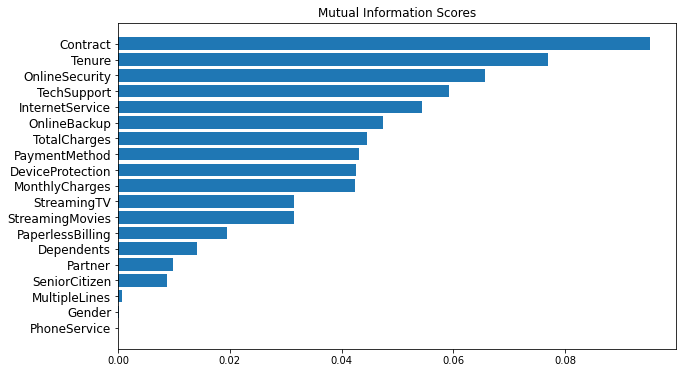

In [21]:
# Calcola e grafica i valori di MI.
mi_scores = compute_mi_scores(X_train, y_train)
plot_mi_scores(mi_scores)

Dall'analisi, risultano esserci 3 feature in particolare che non hanno particamente quasi alcuna influenza sull'output: `Gender`, `PhoneService`, `MultipleLines`.   
Grafichiamone la relazione con la variabile target.

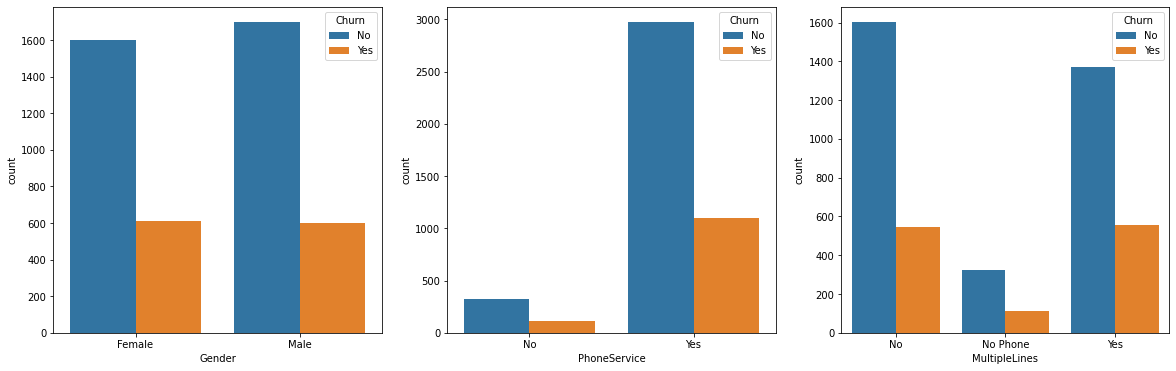

In [22]:
plot_discrete_relation(
    X_train[['Gender', 'PhoneService', 'MultipleLines']],
    y_train,
    max_plots_per_row = 3,
    figsize = (20, 6)
)

Effettivamente, osservando i grafici, non sembra che queste 3 feature influiscano molto sul valore della variabile `Churn`.   
Decido quindi di semplificare il dataset eliminandole.

In [23]:
X_train.drop(['Gender', 'PhoneService', 'MultipleLines'], axis = 1, inplace = True)
X_test.drop(['Gender', 'PhoneService', 'MultipleLines'], axis = 1, inplace = True)

A questo punto, proseguo con la visualizzazione della relazione tra la variabile target e la prima e terza feature che hanno ottenuto il punteggio di MI più alto.

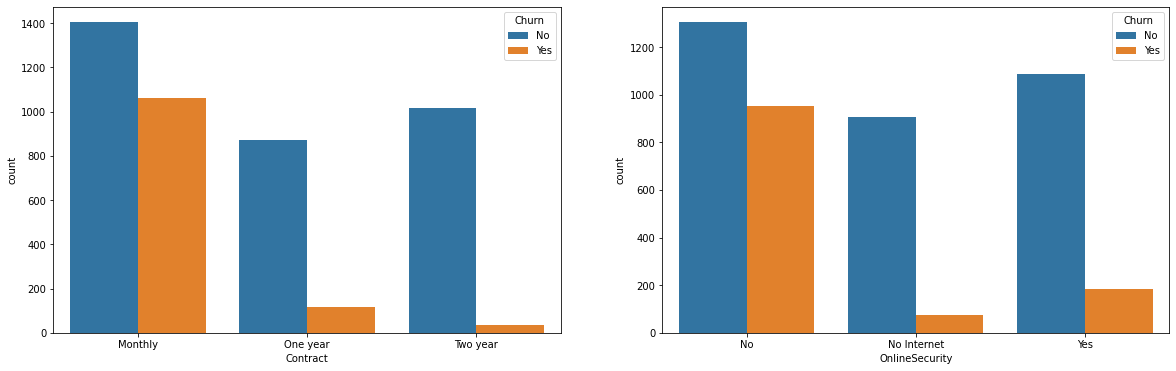

In [24]:
plot_discrete_relation(
    X_train[['Contract', 'OnlineSecurity']],
    y_train,
    max_plots_per_row = 2,
    figsize = (20, 6)
)

Questa volta possiamo osservare come invece queste due feature abbiamo una forte influenza sulla variabile target.
Possiamo osservare che i clienti con contratto mensile sono più propensi a cambiare operatore e che più la durata del contratto aumenta (mensile, annuale, biennale) più gli utenti tendono a rimanere fedeli al proprio operatore.   
Anche la sicurezza online fa la differenza: i clienti che non ne usufruiscono sono più propensi a lasciare il proprio operatore.

Analizziamo ora le tre colonne numeriche: `TotalCharges`, `MonthlyCharges` e `Tenure`.   
Mostrerò tre grafici per visualizzare la relazione che hanno tra loro e con la variabile target.

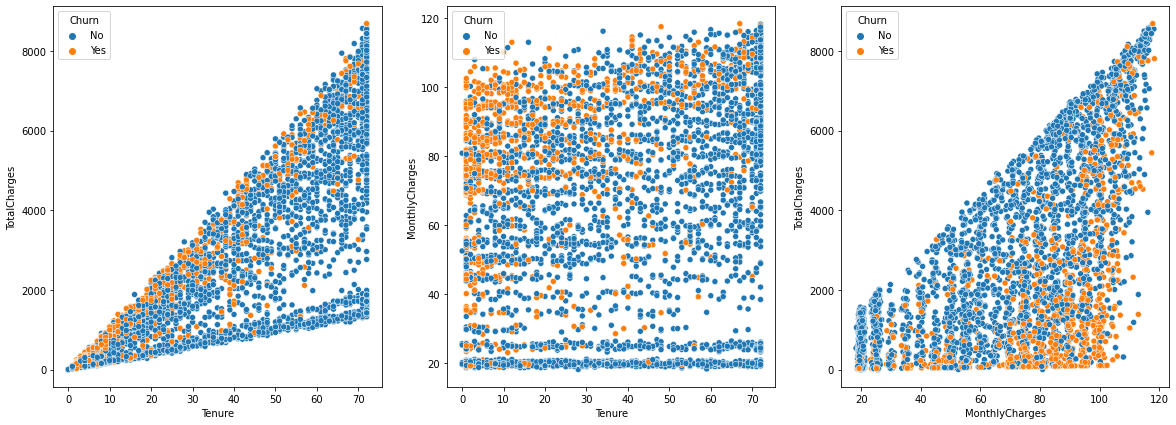

In [25]:
fig, axs = plt.subplots(ncols = 3, figsize = (20, 7))
sns.scatterplot(x = X_train['Tenure'], y = X_train['TotalCharges'], hue = y_train, ax = axs[0])
sns.scatterplot(x = X_train['Tenure'], y = X_train['MonthlyCharges'], hue = y_train, ax = axs[1])
sns.scatterplot(x = X_train['MonthlyCharges'], y = X_train['TotalCharges'], hue = y_train, ax = axs[2])
plt.subplots_adjust(wspace = 0.2)
plt.show()

Osservando questi grafici, si può notare che gli utenti che intendono lasciare la compagnia tendono a concentrarsi tra quelli che pagano di più mensilmente e che si sono abbonati alla compagnia da meno tempo (la regione in alto a sinistra del grafico al centro).   
Da notare anche che tra le feature `TotalCharges` e `Tenure` c'è una relazione grosso modo lineare.

Visualizziamo ora la matrice di correlazione per queste feature.

<AxesSubplot:>

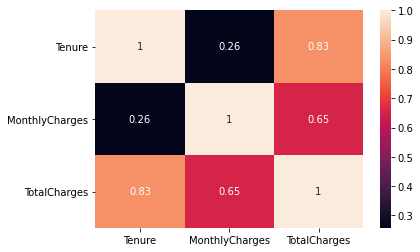

In [26]:
sns.heatmap(data = X_train.corr(), annot = True)

Come potevamo aspettarci dopo aver osservato i grafici, la matrice mostra una buona correlazione tra la feature `TotalCharges` e la feature `Tenure`, nonché una discreta correlazione con la feature `MonthlyCharges`.

Può essere interessante capire se la feature `TotalCharges` è esattamente pari al prodotto delle altre due.

Text(0, 0.5, 'Tenure * MonthlyCharges')

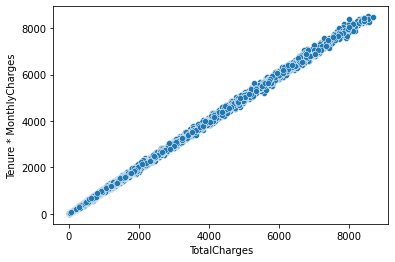

In [27]:
sns.scatterplot(x = X_train['TotalCharges'], y = X_train['Tenure'] * X_train['MonthlyCharges'])
plt.ylabel('Tenure * MonthlyCharges')

`TotalCharges` è molto simile al prodotto tra altre due colonne, ma non è esattamente uguale.
Questo può essere dovuto a una sorta di "rumore" presente nei valori di `TotalCharges` rilevati, ma forse soprattutto a possibili cambiamenti di `MonthlyCharges` nel corso del tempo.

In ogni caso, la relazione tra `TotalCharges` e `Tenure` sembra essere grosso modo lineare.
Per sfoltire il dataset, decido quindi di eliminare la feature `TotalCharges`.

In [28]:
X_train = X_train.drop('TotalCharges', axis = 1)
X_test = X_test.drop('TotalCharges', axis = 1)

score_model(X_train, y_train)

0.7943152594678

Complessivamente finora abbiamo ottenuto un dataset più semplice (eliminando 4 feature: `Gender`, `PhoneService`, `MultipleLines` e `TotalCharges`), sacrificando pochissimo in termini di accuratezza.

Indaghiamo adesso meglio sulla relazione tra la feature `Tenure` e la variabile target.

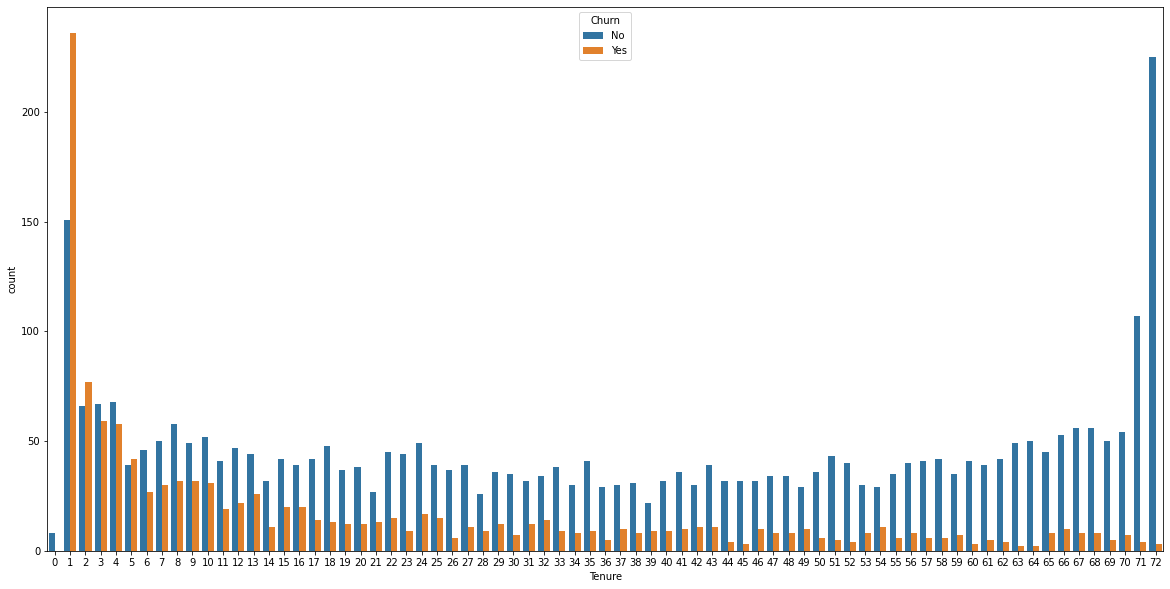

In [29]:
plot_discrete_relation(
    X_train[['Tenure']],
    y_train,
    max_plots_per_row = 2,
    figsize = (20, 10)
)

Come si può osservare, i clienti che tendono a lasciare il proprio operatore sono sopratutto quelli che si sono abbonati al proprio operatore da poco tempo.   
Per ottimizzare il modello, potrebbe essere utile codificare quest'informazione in maniera esplicita, costruendo una nuova feature che suddivida la feature `Tenure` in intervalli temporali.
La speranza è che questo aiuti il modello ad imparare meglio questa relazione.

In [30]:
# Funzione che restituisce l'intervallo temporale corrispondente ad un certo valore di Tenure.
# Ho scelto una determinata suddivisione in modo intuitivo, osservando il grafico sopra, nel tentativo di
# evidenziare quelle che mi sembrano le fasce temporali più rilevanti.
def split_tenure(tenure):
    
    # Il primo mese potrebbe essere di prova.
    if (tenure <= 1):
        return '00-01'
    
    # I primi mesi sono cruciali, perché gli utenti verificano la qualità dell'operatore già da subito.
    elif (tenure <= 4):
        return '02-04'
    
    # Primo e secondo anno.
    elif (tenure <= 13):
        return '05-13'
    elif (tenure <= 25):
        return '14-25'
    
    # Dopo il secondo anno il trend tende a diventare più stabile.
    elif (tenure <= 43):
        return '26-43'
    
    # In questa fascia coloro che rimangono diventano sempre di più rispetto a quelli che lasciano.
    elif (tenure <= 60):
        return '44-60'
    
    # Da questo punto in poi, coloro che rimangono aumentano ancora di più.
    else:
         return '61+'

# Funzione che costruisce la feature TenureGroup, che suddivide la feature Tenure in intervalli temporali.
def build_tenure_group(data):
    feature = pd.DataFrame()
    feature['TenureGroup'] = data['Tenure'].apply(split_tenure).astype('category')
    return feature

In [31]:
# Costruisco la feature TenureGroup per il training set.
train_tenure_group = build_tenure_group(X_train)

Analizziamo la relazione tra questa feature e l'output.

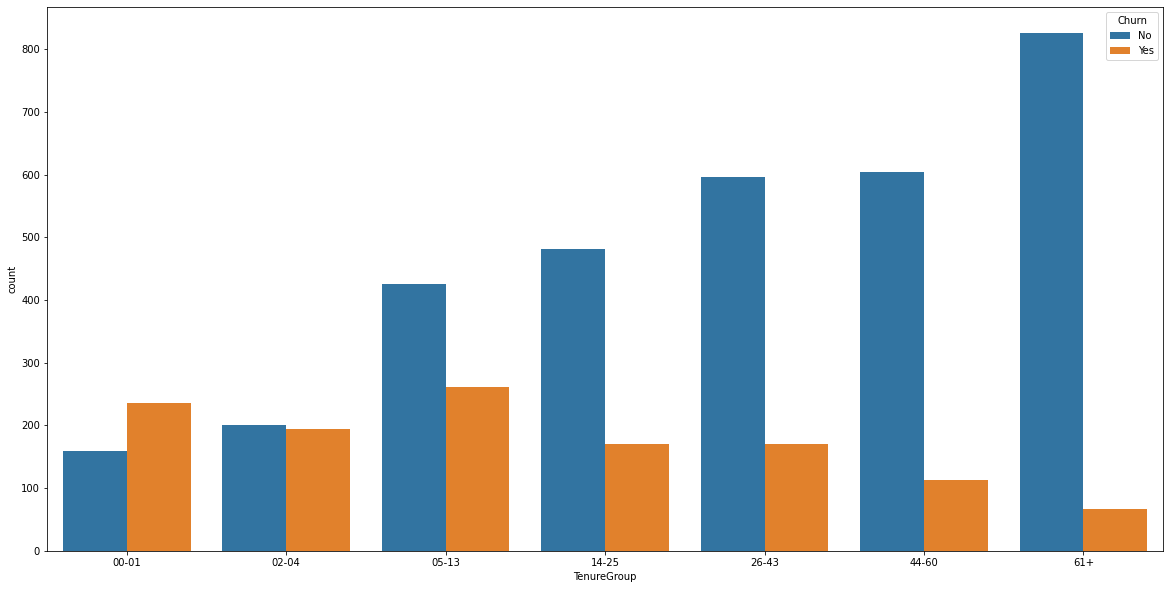

In [32]:
plot_discrete_relation(
    train_tenure_group[['TenureGroup']],
    y_train,
    max_plots_per_row = 2,
    figsize = (20, 10)
)

La feature sembra avere un forte legame con la variabile target.   
Potrei quindi provare a sostituire la feature `Tenure` originaria con questa nuova feature.

In [33]:
X_train = X_train.drop('Tenure', axis = 1).join(train_tenure_group)
X_test  = X_test.drop('Tenure', axis = 1).join(build_tenure_group(X_test))

X_train

,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TenureGroup
0,Yes,No,No,DSL,No,No,No,No,No,No,Monthly,No,E-Check,43.95,02-04
1,No,Yes,Yes,Fiber Optic,Yes,No,No,Yes,No,No,Monthly,Yes,Bank Tranfer,86.80,61+
2,No,Yes,Yes,No,No Internet,No Internet,No Internet,No Internet,No Internet,No Internet,Monthly,No,Mailed Check,20.30,02-04
3,No,Yes,No,DSL,Yes,No,Yes,Yes,Yes,Yes,Two year,No,E-Check,83.20,61+
4,Yes,No,No,No,No Internet,No Internet,No Internet,No Internet,No Internet,No Internet,Two year,No,Credit Card,19.60,44-60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4502,No,No,No,No,No Internet,No Internet,No Internet,No Internet,No Internet,No Internet,Two year,Yes,E-Check,21.10,44-60
4503,Yes,No,No,Fiber Optic,No,No,No,No,Yes,Yes,Monthly,Yes,E-Check,94.20,14-25
4504,No,Yes,Yes,No,No Internet,No Internet,No Internet,No Internet,No Internet,No Internet,Two year,No,Bank Tranfer,25.45,26-43
4505,No,No,No,DSL,Yes,No,No,Yes,No,No,Monthly,No,Credit Card,56.35,14-25


Vediamo che impatto ha avuto tutto ciò sulle performance.

In [34]:
score_model(X_train, y_train)

0.7987555093995092

Abbiamo migliorato leggermente le performance, quindi questa nuova feature sembra aiutare il modello ad apprendere meglio la relazione tra la vecchia feature `Tenure` e la variabile target.

Concentriamoci ora sulle feature relative ai servizi Internet aggiuntivi.
Tutte le colonne relative a questi servizi ammettono tra i propri valori "No Internet".
Questo valore sembra ridondante, in quanto la colonna `InternetService` è già in grado di comunicarci il fatto che l'utente non usufruisce del servizio Internet: ogni qualvolta questa colonna assume valore "No", tutte le colonne relative ai servizi Internet assumono valore "No Internet".   
Per semplificare i dati, potrebbe pertanto essere opportuno sostituire tutte le occorrenze del valore "No Internet" con un semplice "No", eliminando quindi una inutile feature che si verrebbe a creare durante la fase di codifica One-Hot.

In [35]:
# Funzione per sostituire tutti i valori "No Internet" con "No".
def remove_no_internet_value(data):
    return data.replace('No Internet', 'No')

X_train = remove_no_internet_value(X_train)
X_test  = remove_no_internet_value(X_test)

In [36]:
score_model(X_train, y_train)

0.7989774849821951

Questa modifica non ha avuto alcun impatto negativo sulle performance del modello (anzi, sembra esserci stato un leggerissimo miglioramento), e abbiamo quindi semplificato ulteriormente il dataset senza problemi.

Procedo ora con l'analisi della feature `MonthlyCharges`, che si posiziona all'incirca a metà della classifica dei valori di MI.   
Vediamo che relazione ha con la variabile target.

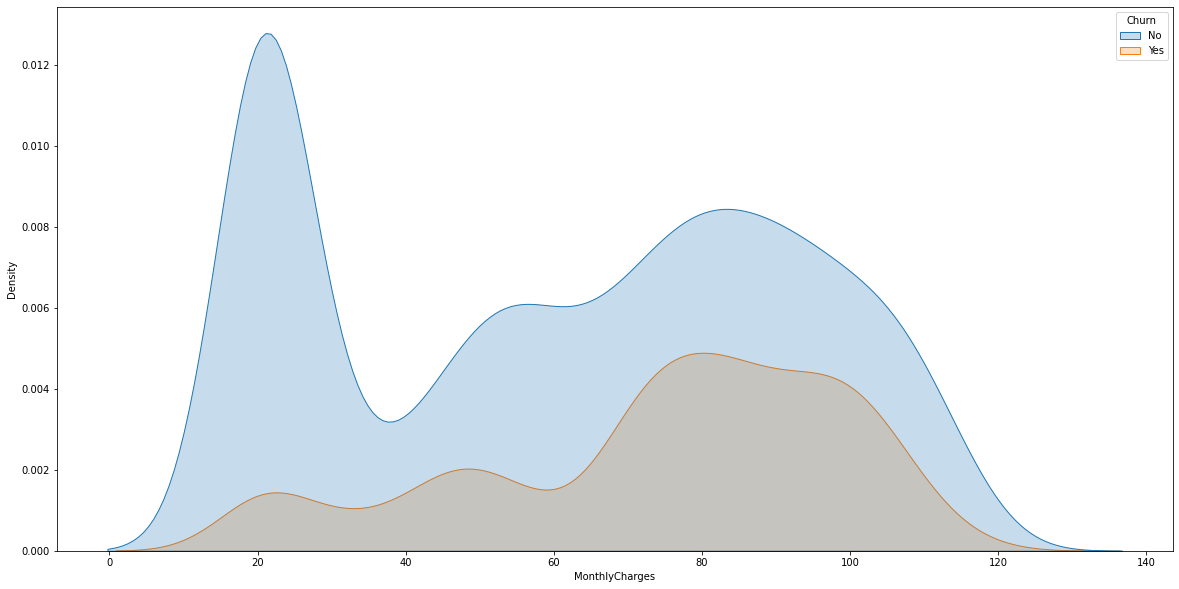

In [37]:
plot_continous_relation(
    X_train[['MonthlyCharges']],
    y_train,
    max_plots_per_row = 2,
    figsize = (20, 10)
)

Come si poteva intuire, i clienti che non vogliono lasciare il proprio operatore sono sopratutto quelli che pagano meno (almeno tendenzialmente). Mano a mano che i prezzi aumentano, i clienti tendono sempre più a voler cambiare operatore.

Viste le modifiche apportate al dataset, potrebbe essere utile a questo punto ricalcolare i valori di Mutual Information.

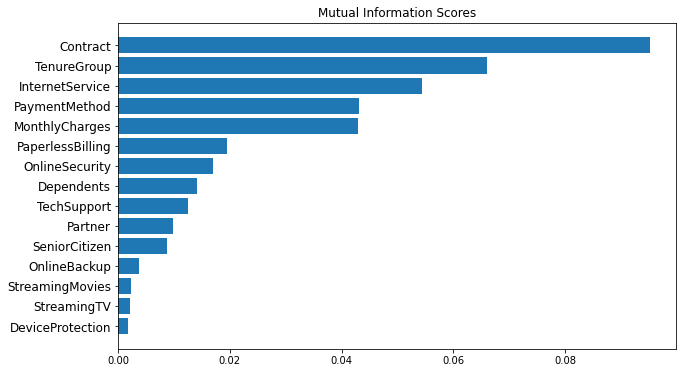

In [38]:
# Calcola e grafica i valori di MI.
mi_scores = compute_mi_scores(X_train, y_train)
plot_mi_scores(mi_scores)

Indaghiamo ora meglio sulla relazione tra i vari servizi di cui l'utente può usufruire e la variabile target.

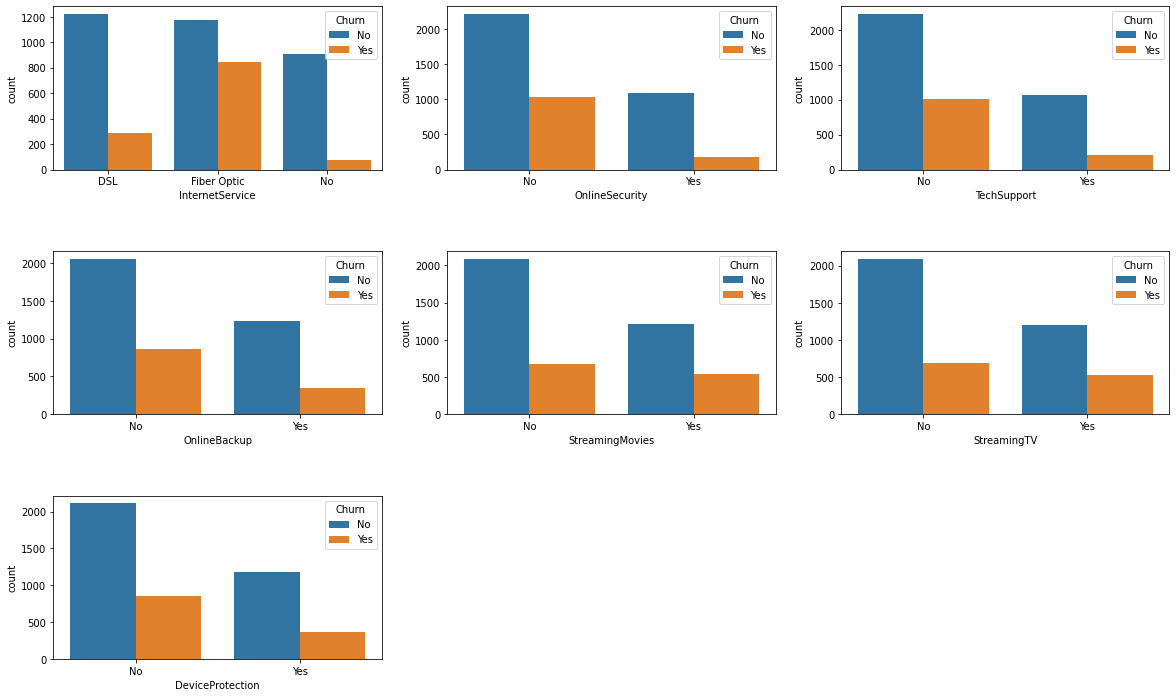

In [39]:
plot_discrete_relation(
    X_train[['InternetService', 'OnlineSecurity', 'TechSupport', 'OnlineBackup', 'StreamingMovies', 'StreamingTV', 'DeviceProtection']],
    y_train,
    max_plots_per_row = 3,
    figsize = (20, 12)
)

Possiamo osservare come gli utenti che usufruiscono del servizio Internet tramite fibra ottica siano molto più propensi a lasciare rispetto a coloro che non ne usufruiscono affatto.   
La relazione tra la variabile target e gli altri servizi è più o meno importante a seconda del tipo di servizio: le feature `OnlineSecurity` e `TechSupport` sembrano essere le più rilevanti (gli utenti che non ne usufruiscono sono più propensi a lasciare), mentre le altre quattro sembrano un po' meno rilevanti (`DeviceProtection` in particolare).

Può essere interessante notare come gli utenti che usufruiscono dei servizi `StreamingMovies` e `StreamingTV` siano più propensi a lasciare l'operatore.
Mi chiedo se non ci sia una qualche correlazione tra le feature `StreamingTV` e `StreamingMovies`.
Intuitivamente, sembrano due feature piuttosto "accoppiate".   
Qui sotto calcolo quindi il coefficiente di correlazione tra le due variabili.

In [40]:
X_train['StreamingTV'].cat.codes.corr(X_train['StreamingMovies'].cat.codes)

0.5372785241229052

Abbiamo una discreta correlazione tra le due variabili, anche se non forte.
Poiché queste due feature hanno anche ottenuto un punteggio di MI non molto alto, posso quindi pensare di semplificare ulteriormente il dataset eliminando una delle due, ad esempio `StreamingTV` (che secondo lo score MI sembra essere leggermente meno rilevante rispetto all'altra).

In [41]:
X_train = X_train.drop('StreamingTV', axis = 1)
X_test  = X_test.drop('StreamingTV', axis = 1)

score_model(X_train, y_train)

0.7987552633068454

L'accuracy è calata di pochissimo. Abbiamo semplificato ulteriormente il dataset.

Per concludere, analizziamo la relazione tra la variabile target e le feature che non abbiamo ancora graficato.

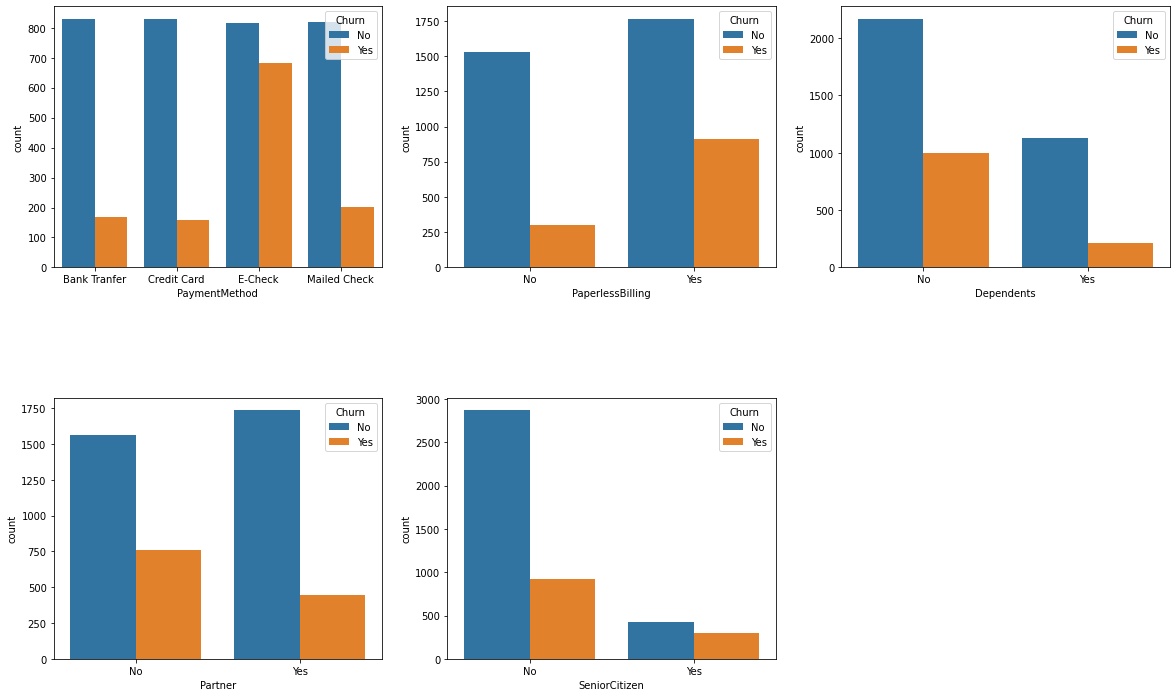

In [42]:
plot_discrete_relation(
    X_train[['PaymentMethod', 'PaperlessBilling', 'Dependents', 'Partner', 'SeniorCitizen']],
    y_train,
    max_plots_per_row = 3,
    figsize = (20, 12)
)

Osserviamo come gli utenti che effettuano pagamento elettronico siano molto più propensi a lasciare l'operatore rispetto agli altri, così come quelli che ricevono fatturazione senza carta e quelli che non hanno partner.
Da notare che i clienti più anziani sono più propensi a cambiare operatore (il che mi sorprende, perché onestamente credevo fosse il contrario).

## Addestramento e Valutazione
Arrivati a questo punto, addestrerò il modello sul train set corrente e lo valuterò sul test set.

In [43]:
classifier = LogisticRegressionCV(max_iter = 1000, random_state = 13)
model = make_pipeline(StandardScaler(), classifier)
encoded_train = encode(X_train, y_train)
model.fit(*encoded_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregressioncv',
                 LogisticRegressionCV(max_iter=1000, random_state=13))])

Valutiamo l'accuratezza del modello sul training set.

In [44]:
model.score(*encoded_train)

0.8038606611936987

Valutiamo ora l'accuratezza del modello sul test set.

In [45]:
X_test_enc, y_test_enc = encode(X_test, y_test)
model.score(X_test_enc, y_test_enc)

0.8154392191659272

L'accuratezza sul test set si aggira intorno all'81/82% (il modello sbaglia meno di 1 volta su 5).
Non è eccezionale, ma credo sia accettabile, almeno come primo prototipo.
Mi lascia però perplesso il fatto che l'accuracy sul test set sia superiore a quella sul training set.

Per analizzare meglio le performance del modello sul test set, mostro qua sotto la matrice di confusione.

Text(0.5, 15.0, 'Predicted Churn')

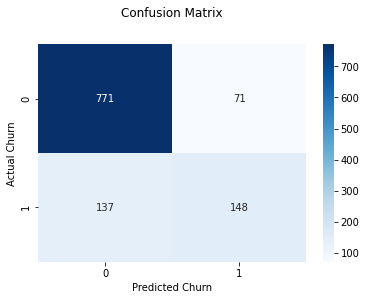

In [46]:
y_test_pred = model.predict(X_test_enc)

conf_matrix = confusion_matrix(y_test_enc, y_test_pred)
sns.heatmap(pd.DataFrame(conf_matrix), annot = True, cmap = 'Blues', fmt = 'g')
plt.title('Confusion Matrix', y = 1.1)
plt.ylabel('Actual Churn')
plt.xlabel('Predicted Churn')

Abbiamo 137 falsi negativi e 71 falsi positivi. Il modello sembra quindi commettere molti più errori sui positivi.
Ciò è probabilmente dovuto al fatto che il dataset è sbilanciato, ovvero ci contiene molti più esempi negativi che positivi.

Analizziamo adesso i pesi assegnati alle varie feature durante il processo di apprendimento.

In [47]:
weights = classifier.coef_[0]
weights

array([ 0.0583854 ,  0.06058443, -0.05696046, -0.22244609, -0.08056261,
        0.01866705, -0.12845003,  0.20991479,  0.18828045,  0.06701333,
       -0.31956242, -0.67329316,  0.39279872, -0.40161751, -0.00697501,
        0.161728  , -0.01103787, -0.18147973, -0.42159709, -0.57299062,
       -0.69887173, -0.72976218, -0.90769343])

Visualizziamo ora i pesi con un grafico a barre.

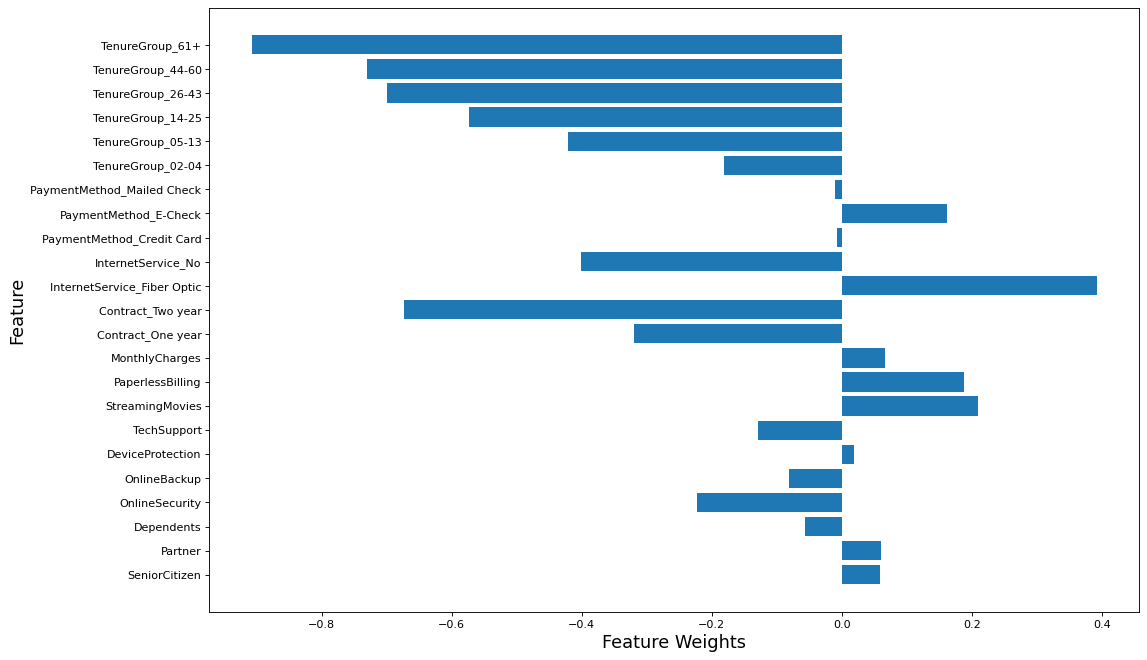

In [48]:
# Funzione per visualizzare i pesi con un grafico a barre.
def plot_feature_weights(weights):
    plt.figure(figsize = (15, 10), dpi = 80)
    plt.barh(X_test_enc.columns, weights, align = 'center')
    plt.xlabel('Feature Weights', size = 16)
    plt.ylabel('Feature', size = 16)
    plt.show()

plot_feature_weights(weights)

La magnitudine dei pesi è in linea di massima abbastanza in accordo con le analisi fatte in precedenza: le feature che hanno pesi più alti (in valore assoluto) sono tendenzialmente quelle che avevano ottenuto valori più alti di Mutua Informazione.